In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEMhd
from importlib import reload  
KSEMhd = reload(KSEMhd)
from KSEMhd import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_brooklyn"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067522 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067576 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067189 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9704, 0.0296], [0.04200000000000004, 0.958]],
 'gate_qubits': [(64,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-05-25 22:51:51-04:00


In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True, meas_x = False):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if meas_x:
        for i in range(n_qubits):
            total_circ.h(i)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

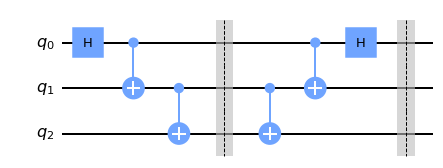

In [8]:
single_iter(n_qubits).draw("mpl")

10


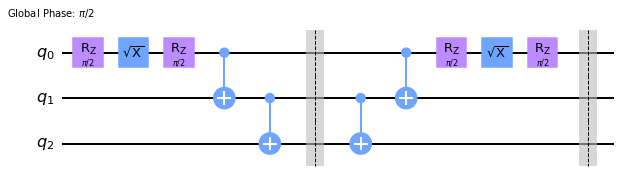

In [9]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [10]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 9.275249258271653e-05 sec
T2: 9.733613343913872e-05 sec
Circuit Operation Time: 2.2104888888888887e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [11]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [12]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'000': 55283,
 '110': 518,
 '001': 3314,
 '011': 1677,
 '010': 2722,
 '101': 490,
 '100': 1094,
 '111': 438}

In [13]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEMhd.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9140048691246985
0.8374504245476417
0.7692695153662782
0.7085171338466145
0.6543563491444209
0.6060458667039678
0.5629290249950993
0.5244240631098643
0.4900155120590421
0.45924657968254373

Prob Vec
[0.91975403 0.02650452 0.02540588 0.00944519 0.01095581 0.00274658
 0.00273132 0.00245667]
[0.88154602 0.03805542 0.03530884 0.01747131 0.01322937 0.00495911
 0.00488281 0.00454712]
[0.84248352 0.05241394 0.04194641 0.02566528 0.01535034 0.00816345
 0.00785828 0.00611877]
[0.80703735 0.06315613 0.04957581 0.03323364 0.01820374 0.01048279
 0.009552   0.00875854]
[0.77577209 0.07264709 0.05453491 0.04026794 0.02084351 0.01281738
 0.01194763 0.01116943]
[0.74504089 0.08137512 0.06300354 0.04804993 0.02198792 0.0138092
 0.01348877 0.01324463]
[0.71504211 0.09164429 0.0682373  0.05247498 0.02389526 0.0176239
 0.01644897 0.01463318]
[0.68673706 0.10089111 0.07444763 0.05976868 0.02659607 0.01831055
 0.01686096 0.01638794]
[0.65939331 0.10824585 0.08042908 0.06529236 0.02731323 0.02111816

In [14]:
def meas_mat(num_qubits):# H, measurement matrix for vectorized density matrix
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = csc_matrix((nrows, ncols), dtype=complex)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1 # take out the diagonal terms in vectorized density matrix
    return mat

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [15]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067522 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067576 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067189 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [16]:
np.random.seed(7)

tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=den_simu_for_tomo)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=np.random.randint(10**8)).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.8407464496728055
0.7719026946894153
0.7094150588920353
0.6557917728322877
0.6270402722574331
0.5689031861619495
0.5386031703106808
0.4961244567560953
0.46416104870078007
0.44055715019320263

Tomography Prob Vec
[0.91304975 0.02441061 0.02037211 0.0110156  0.01459023 0.00409111
 0.00757074 0.00489986]
[0.87409563 0.03832255 0.03506148 0.0160718  0.01443981 0.00719194
 0.00868642 0.00613037]
[0.83490015 0.04592423 0.04364429 0.02998251 0.01757957 0.0097827
 0.01224944 0.00593712]
[0.80138849 0.06397982 0.05299555 0.03364201 0.02368113 0.01107175
 0.00703044 0.00621082]
[0.78188629 0.07050993 0.05567742 0.03456697 0.01600886 0.01373697
 0.01391717 0.01369639]
[0.74125956 0.08307998 0.06647789 0.03961382 0.02570251 0.0153709
 0.01073635 0.01775899]
[0.7182251  0.08438139 0.07274961 0.05060161 0.02557181 0.01535068
 0.01277856 0.02034124]
[0.68561916 0.09993319 0.07298768 0.05786138 0.02250269 0.02285221
 0.02606601 0.01217768]
[0.65871853 0.1089681  0.08265516 0.0644802

## Kalman Smoother

In [17]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

## Add X-basis measurements

In [18]:
total_simu_probs_x = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_x = True), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    total_simu_probs_x.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [19]:
total_simu_probs_x

[array([0.13575745, 0.12409973, 0.13131714, 0.11734009, 0.1313324 ,
        0.11982727, 0.12487793, 0.115448  ]),
 array([0.13851929, 0.12226868, 0.13204956, 0.11776733, 0.13102722,
        0.11911011, 0.12638855, 0.11286926]),
 array([0.13856506, 0.12101746, 0.13233948, 0.11708069, 0.13356018,
        0.11784363, 0.12866211, 0.1109314 ]),
 array([0.14097595, 0.12010193, 0.13397217, 0.11442566, 0.13299561,
        0.11763   , 0.12652588, 0.1133728 ]),
 array([0.14073181, 0.11914062, 0.13517761, 0.11312866, 0.13519287,
        0.11747742, 0.12812805, 0.11102295]),
 array([0.13989258, 0.12043762, 0.13552856, 0.11431885, 0.13522339,
        0.11387634, 0.12876892, 0.11195374]),
 array([0.1434021 , 0.11865234, 0.13644409, 0.11470032, 0.13591003,
        0.11399841, 0.13157654, 0.10531616]),
 array([0.14445496, 0.11604309, 0.13723755, 0.11296082, 0.13774109,
        0.11329651, 0.13061523, 0.10765076]),
 array([0.1439209 , 0.11933899, 0.135849  , 0.11201477, 0.13827515,
        0.11331177, 

In [20]:
observs = []
for i in range(len(total_simu_probs)):
    z_meas_p = total_simu_probs[i]
    x_meas_p = total_simu_probs_x[i]
    observs.append(np.append(z_meas_p, x_meas_p))
observs

[array([0.91975403, 0.02650452, 0.02540588, 0.00944519, 0.01095581,
        0.00274658, 0.00273132, 0.00245667, 0.13575745, 0.12409973,
        0.13131714, 0.11734009, 0.1313324 , 0.11982727, 0.12487793,
        0.115448  ]),
 array([0.88154602, 0.03805542, 0.03530884, 0.01747131, 0.01322937,
        0.00495911, 0.00488281, 0.00454712, 0.13851929, 0.12226868,
        0.13204956, 0.11776733, 0.13102722, 0.11911011, 0.12638855,
        0.11286926]),
 array([0.84248352, 0.05241394, 0.04194641, 0.02566528, 0.01535034,
        0.00816345, 0.00785828, 0.00611877, 0.13856506, 0.12101746,
        0.13233948, 0.11708069, 0.13356018, 0.11784363, 0.12866211,
        0.1109314 ]),
 array([0.80703735, 0.06315613, 0.04957581, 0.03323364, 0.01820374,
        0.01048279, 0.009552  , 0.00875854, 0.14097595, 0.12010193,
        0.13397217, 0.11442566, 0.13299561, 0.11763   , 0.12652588,
        0.1133728 ]),
 array([0.77577209, 0.07264709, 0.05453491, 0.04026794, 0.02084351,
        0.01281738, 0.011947

### Initialize

In [21]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [22]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = observs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [23]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 16, 4096)

### EM and Smoother - Total

Use longest iterations

In [24]:
total_smoother_dens = []
total_smoother_purs = []

# observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEMhd.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 749.44, Last ll 739.44
Iteration     1, New log-likelihood 1.05390e+03, Last log-likelihood 7.49442e+02, Change 3.04460e+02
Iteration     2, New log-likelihood 1.16063e+03, Last log-likelihood 1.05390e+03, Change 1.06733e+02
Iteration     3, New log-likelihood 1.26595e+03, Last log-likelihood 1.16063e+03, Change 1.05312e+02
Iteration     4, New log-likelihood 1.37700e+03, Last log-likelihood 1.26595e+03, Change 1.11054e+02


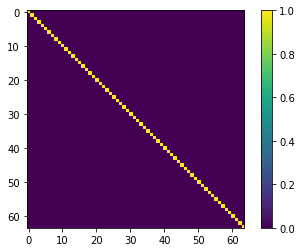

In [25]:
plt.imshow(realF.real)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [26]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [27]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [28]:
total_smoother_dens[0].diagonal().flatten()

matrix([[0.91915529+0.j, 0.02473953+0.j, 0.02623377+0.j, 0.00175142+0.j,
         0.00680449+0.j, 0.00464702+0.j, 0.00972568+0.j, 0.00694279+0.j]])

In [29]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[0.91915529+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.02473953+0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.02623377+0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.00175142+0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.00680449+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.00464702+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.00972568+0.j, 0.

In [30]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

0.016525267311063907
0.019300119680356484
0.02326604285839254
0.025334704021968066
0.027818368783464012
0.027408973683932816
0.03256822464934401
0.03361583504257784
0.035215897952365266
0.035654645159767726


In [31]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.8466335497912549
0.7796679235132871
0.7156096377532889
0.6604865686253861
0.6135496399537431
0.5699914066120224
0.5299132593551693
0.4939970112354043
0.4612469514936165
0.43809164305183623


## Check the fidelity between estimated state and the real state in the simulator

In [32]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.9761380577236294 Tomo Fid: 0.9639725612615057
Iteration 2 KS Fid: 0.9744765961935152 Tomo Fid: 0.9583527155378678
Iteration 3 KS Fid: 0.9669728379986999 Tomo Fid: 0.959895293220116
Iteration 4 KS Fid: 0.9852216303942682 Tomo Fid: 0.968969615365443
Iteration 5 KS Fid: 0.9864474355949587 Tomo Fid: 0.9623055293126878
Iteration 6 KS Fid: 0.9895207524638951 Tomo Fid: 0.9563536807908218
Iteration 7 KS Fid: 0.9549890584267237 Tomo Fid: 0.9574351319682156
Iteration 8 KS Fid: 0.9862203872737778 Tomo Fid: 0.962508927796024
Iteration 9 KS Fid: 0.9871571316416063 Tomo Fid: 0.9650931213825317
Iteration 10 KS Fid: 0.9860778822364483 Tomo Fid: 0.9761663665422986


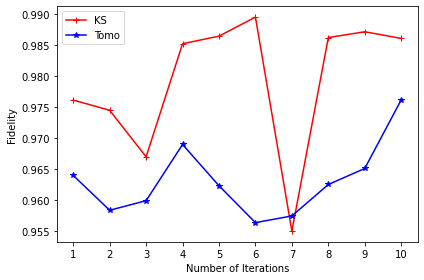

In [33]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.9761380577561394 Tomo Fid: 0.9639725612509689
Iteration 2 KS Fid: 0.9744765960898981 Tomo Fid: 0.9583527154236288
Iteration 3 KS Fid: 0.9669728378533018 Tomo Fid: 0.9598952931173409
Iteration 4 KS Fid: 0.9852216302758291 Tomo Fid: 0.9689696158961516
Iteration 5 KS Fid: 0.9864474355949583 Tomo Fid: 0.9623055292598095
Iteration 6 KS Fid: 0.9895207524638965 Tomo Fid: 0.9563536806205245
Iteration 7 KS Fid: 0.9549890584267252 Tomo Fid: 0.9574351317372324
Iteration 8 KS Fid: 0.9862203872737796 Tomo Fid: 0.9625089276304206
Iteration 9 KS Fid: 0.9871571316416075 Tomo Fid: 0.9650931213825301
Iteration 10 KS Fid: 0.9860778822364514 Tomo Fid: 0.9761663665423002


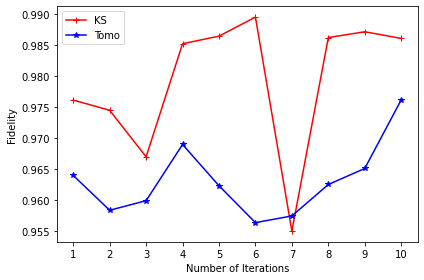

In [34]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.049270902435738194 Tomo Norm: 0.08497674442033847
Iteration 2 KS Norm: 0.055618999504513204 Tomo Norm: 0.08135471626309931
Iteration 3 KS Norm: 0.06578165854149363 Tomo Norm: 0.08748264848060947
Iteration 4 KS Norm: 0.06393125412463645 Tomo Norm: 0.07934945467374935
Iteration 5 KS Norm: 0.06938841629544702 Tomo Norm: 0.07675099582335135
Iteration 6 KS Norm: 0.07470474899030748 Tomo Norm: 0.08840239296179703
Iteration 7 KS Norm: 0.10286600966493288 Tomo Norm: 0.09632599469878407
Iteration 8 KS Norm: 0.09001030480020022 Tomo Norm: 0.08519601288645345
Iteration 9 KS Norm: 0.09455142065355976 Tomo Norm: 0.0946727276200284
Iteration 10 KS Norm: 0.10032416581479943 Tomo Norm: 0.10444763264006023


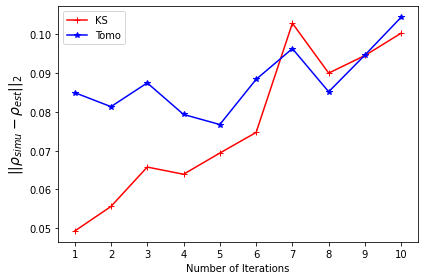

In [35]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

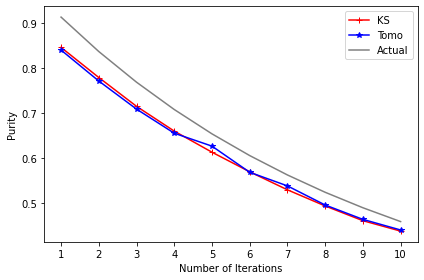

In [36]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

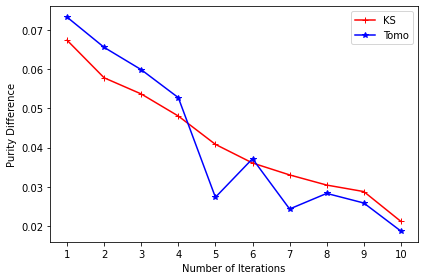

In [37]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()